In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import math
import optuna
from scipy.integrate import odeint

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Specifying parameters for PFR and other constants taken Siettos et al.'s work (1998)

T0_s = 440 #440 # inlet temperature

k_0 = 3.34 * (np.power(10,8)) # pre-exponential constant

C_p = 25 # heat capacity of reacting liquid

rho_L = 47 # density of reacting liquid

T_s = 423 # steady-state reactor temperature                

u = 2 # volumetric flow rate  (F/A) Superficial velocity

E_by_R = 8600 # activation energy (E/R)

delH_term = -44000 # enthalpy of reaction

U = 25 #Overall heat transfer coeffecient

CA0_s = 1.6 #  steady-state inlet concentration of A

CA_s = 0.11 # steady-state reactor concentration of A         

Tc_s = 293 # steady state cooling temperature

At = 0.01 # Area for heating rate equation

A = 0.002  # Area

t_final = 0.05 #0.01 # end time for numerical simulation

t_step = 0.01 #1e-3 # integration time step h_c

P = np.array([[1060, 22], [22, 0.52]]) # a positive definite matrix             

length = 1 # total length of reactor

N = 10     # number of points to discretize the reactor

# Euler Method

In [16]:
def PFR_simulation_Euler(u, delH_term, k_0, C_p, rho_L, E_by_R, Tc, U, At, A, t_final, t_step, init_C, init_T):

    # Method of lines approximates the spatial derivative using finite difference method which reults in a set of coupled ODE
    
    def method_of_lines_C(C, T):
        'coupled ODES at each node point'
        D = -u * np.diff(C) / np.diff(z) - k_0 * np.exp(-E_by_R/T[1:]) * C[1:]    # for first order
        return np.concatenate([[0], D]) #C0 is constant at entrance


    def method_of_lines_T(C, T):
        'coupled ODES at each node point'
        D = -u * np.diff(T) / np.diff(z) + (-delH_term/(rho_L*C_p)) * k_0 * np.exp(-E_by_R/T[1:])* C[1:] + (U/(rho_L*C_p*A)) * At * (Tc - T[1:]) # for first order
        return np.concatenate([[0], D]) #T0 is constant at entrance

    N = 11     # number of points to discretize the reactor length
    z = np.linspace(0, length, N) # discretized length elements
    
    #initializing arrays
    init_C_A_2_1 = np.zeros(N)
    init_T_2_1 = np.zeros(N)  
    
    init_C_A_2_2 = np.zeros(N)
    init_T_2_2 = np.zeros(N)   
    
    init_C_A_3 = np.zeros(N)
    init_T_3 = np.zeros(N)    
    
    C_A_3 = np.zeros(N)
    T_3 = np.zeros(N)    
    
    
    dCAdt1 = method_of_lines_C(init_C, init_T)
    dTdt1 = method_of_lines_T(init_C, init_T)
    
    for i in range(len(init_C)):        
        init_C_A_2_1[i] = init_C[i] + dCAdt1[i] * t_step / 2
        init_T_2_1[i] = init_T[i] + dTdt1[i] * t_step / 2
        
    dCAdt2_1 = method_of_lines_C(init_C_A_2_1, init_T_2_1)
    dTdt2_1 = method_of_lines_T(init_C_A_2_1, init_T_2_1)        
        
    for i in range(len(init_C)):
        init_C_A_2_2[i] = init_C[i] + dCAdt2_1[i] * t_step / 2
        init_T_2_2[i] = init_T[i] + dTdt2_1[i] * t_step / 2
        
    dCAdt2_2 = method_of_lines_C(init_C_A_2_2, init_T_2_2)
    dTdt2_2 = method_of_lines_T(init_C_A_2_2, init_T_2_2)           
        
    for i in range(len(init_C)):       
        init_C_A_3[i] = init_C[i] + dCAdt2_2[i] * t_step / 2
        init_T_3[i] = init_T[i] + dTdt2_2[i] * t_step / 2
        
    dCAdt3 = method_of_lines_C(init_C_A_3, init_T_3)
    dTdt3 = method_of_lines_T(init_C_A_3, init_T_3)           
        
    dCAdt2 = np.add(dCAdt2_1,dCAdt2_2)
    dCAdt2 = np.divide(dCAdt2,2)
      
    dTdt2 = np.add(dTdt2_1,dTdt2_2)
    dTdt2 = np.divide(dTdt2,2)        

    for i in range(len(init_C)):      
        C_A_3[i] = init_C[i] + t_step / 6 * (dCAdt1[i] + 4*dCAdt2[i] + dCAdt3[i])     
        T_3[i] = init_T[i] + t_step / 6 * (dTdt1[i] + 4*dTdt2[i] + dTdt3[i])    

    return C_A_3 , T_3  

# Data generation (PI-RNN) collocation points

In [4]:
# generating inputs and initial states for PFR

u2_physics_list = np.linspace(100, 300, 20) # u2 is the cooling temp
T_physics_initial = np.linspace(300, 500, 20)  # inlet temperature
CA_physics_initial = np.linspace(0.5, 3, 20)  # inlet concentration

In [5]:
# Grouping the initial state vectors

T_physics_start = list()
CA_physics_start = list()

for T in T_physics_initial:
    for CA in CA_physics_initial:
        CA_physics_start.append(CA)
        T_physics_start.append(T)
            
print("number of initial conditions: {}".format(len(CA_physics_start)))

# convert to np.arrays
CA_physics_start = np.array([CA_physics_start])
T_physics_start = np.array([T_physics_start])
x_physics_original = np.concatenate((CA_physics_start.T, T_physics_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_physics_original is {}".format(x_physics_original.shape))

number of initial conditions: 400
shape of x_physics_original is (400, 2)


In [6]:
# Steady state values of concnetration and temperature for this system is as given below

CA_ss = [1.6, 1.5111947036559625, 1.417387640197116, 1.3184219134355777, 1.2143091606184162, 1.105331317367263, 0.9921731706476451, 0.8760742913774546, 0.7589642805672522, 0.6435103342443346, 0.5329795659848772]
CA_ss = np.array(CA_ss)

T_ss = [440, 442.537980203289, 445.24937842606676, 448.1391353316486, 451.20586746040226, 454.43809815470087, 457.80935816302986, 461.2725883629541, 464.75519617827314, 468.1574151982801, 471.3575957995257]
T_ss = np.array(T_ss)

In [17]:
# get X and y data for the model

CA_physics_output = list()
T_physics_output = list()
CA_physics_input = list()
T_physics_input = list()
Tc_physics_input = list()


for num_id, u2 in enumerate(u2_physics_list):
    print(f"{num_id + 1} out of {u2_physics_list.shape[0]}")    #just to count and keep track
    Tc = u2 + Tc_s
        
    for C_A_initial, T_initial in x_physics_original:
        Tc_physics_input.append(u2)
        CA_physics_input.append(C_A_initial)
        T_physics_input.append(T_initial)
            
        N = 11     # number of points to discretize the reactor length
        z = np.linspace(0, length, N) # discretized length elements   
        
        # Here, we initilise with the stead state values to validate our simulation model
        init_C = CA_ss
        init_T = T_ss
        
        
        # PFR simulation for a certain initial condition that is not at steady state
        
        #init_C = np.zeros(N)    # Concentration in reactor at t = 0
        #init_C[0] = C_A_initial          # concentration at entrance   
        #init_T = np.zeros(N)    # T in reactor at t = 0
        #for i in range(len(init_T)):
        #    if i == 0:
        #        init_T[i] = T_initial 
        #    else:
        #        init_T[i] = 293   # at room temperature and scaled with Steady State value
            
        C_A_list = [init_C] 
        T_list = [init_T]            
                                
        for _ in range(int(t_final / t_step)):
            
            CA_next, T_next = PFR_simulation_Euler(u, delH_term, k_0, C_p, rho_L, E_by_R, Tc, U, At, A, t_final, t_step, init_C, init_T)
            C_A_list.append(CA_next)
            T_list.append(T_next)
            init_C = CA_next
            init_T = T_next
             
        CA_physics_output.append(C_A_list)
        T_physics_output.append(T_list)

1 out of 20
2 out of 20
3 out of 20
4 out of 20
5 out of 20
6 out of 20
7 out of 20
8 out of 20
9 out of 20
10 out of 20
11 out of 20
12 out of 20
13 out of 20
14 out of 20
15 out of 20
16 out of 20
17 out of 20
18 out of 20
19 out of 20
20 out of 20


# Generating Plots

[1.6, 1.5111947036559625, 1.417387640197116, 1.3184219134355777, 1.2143091606184162, 1.105331317367263, 0.9921731706476451, 0.8760742913774546, 0.7589642805672522, 0.6435103342443346, 0.5329795659848772]
[1.6        1.51063123 1.41675589 1.31777987 1.2136868  1.10477064
 0.9917336  0.87583266 0.75900778 0.64391858 0.53379592]
[1.6        1.51009632 1.41604792 1.3170383  1.21295565 1.10409221
 0.9911659  0.87545097 0.75889826 0.64416149 0.53443863]
[1.6        1.50959728 1.41528531 1.31620178 1.21211583 1.10329579
 0.99047025 0.87493006 0.75863739 0.64424154 0.53491062]
[1.6        1.509138   1.41448874 1.31527869 1.21116874 1.10238131
 0.98964676 0.87427066 0.75822666 0.64416103 0.53521472]
[1.6        1.5087199  1.41367685 1.31428047 1.21011755 1.10134915
 0.98869554 0.87347338 0.75766747 0.64392214 0.53535363]


Text(0.5, 1.0, 'concentration versus length over time')

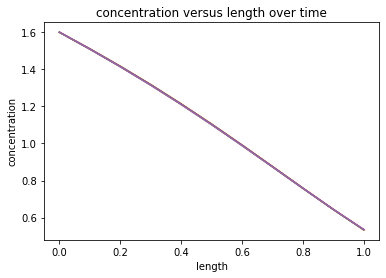

In [19]:
## Concentration profile along the length of reactor over time

import matplotlib.pyplot as plt
count=0
CA0=[]
CA1=[]
CA2=[]
CA3=[]
CA4=[]
CA5=[]

for i in CA_physics_output[0]:
    print(i)
    for j in i:
        #print(j)
        if count==0:
            CA0.append(j)
        if count==1:
            CA1.append(j)
        if count==2:
            CA2.append(j)
        if count==3:
            CA3.append(j)
        if count==4:
            CA4.append(j)
        if count==5:
            CA5.append(j)
    count=count+1
    
    
    
    
N = 11     # number of points to discretize the reactor volume on
z = np.linspace(0, length, N) # discretized volume elements
#plt.plot(z, CA0)
plt.plot(z, CA1)
plt.plot(z, CA2)
plt.plot(z, CA3)
plt.plot(z, CA4)
plt.plot(z, CA5)

plt.xlabel("length")
plt.ylabel("concentration")
plt.title("concentration versus length over time")

Text(0.5, 1.0, 'concentration versus length over time')

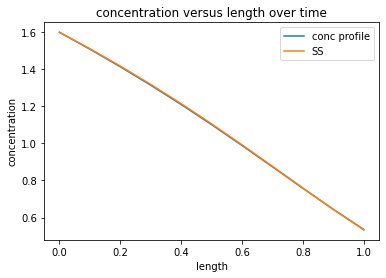

In [20]:
## Plot comparing the steady state and PFR simulation profiles for concentration

CA_ss = [1.6, 1.5111947036559625, 1.417387640197116, 1.3184219134355777, 1.2143091606184162, 1.105331317367263, 0.9921731706476451, 0.8760742913774546, 0.7589642805672522, 0.6435103342443346, 0.5329795659848772]

N = 11     # number of points to discretize the reactor volume on
z = np.linspace(0, length, N) # discretized volume elements
plt.plot(z, CA5, label='conc profile')

    
N = 11     # number of points to discretize the reactor volume on
z = np.linspace(0, length, N) # discretized volume elements
plt.plot(z, CA_ss, label= 'SS')

plt.legend()

plt.xlabel("length")
plt.ylabel("concentration")
plt.title("concentration versus length over time")

[440.         442.5379802  445.24937843 448.13913533 451.20586746
 454.43809815 457.80935816 461.27258836 464.75519618 468.1574152
 471.3575958 ]
[440.         442.65560287 445.37718936 448.26769298 451.33359605
 454.5634154  457.93005658 461.3858214  464.85774522 468.24636191
 471.43139222]
[440.         442.75425938 445.50488873 448.39957315 451.46526241
 454.69302627 458.05543917 461.50418678 464.96591365 468.34139095
 471.51158331]
[440.         442.83699201 445.62918344 448.53392555 451.60075752
 454.82692458 458.18549338 461.62764739 465.07963326 468.4424033
 471.59805232]
[440.         442.90635697 445.74783782 448.66950824 451.73979818
 454.96507154 458.32020554 461.75617029 465.19884142 468.5493059
 471.69068691]
[440.         442.96450206 445.85942057 448.80492722 451.88190157
 455.10736599 458.45955245 461.88972506 465.32348064 468.66201137
 471.78937919]


Text(0.5, 1.0, 'Temperature versus length over time')

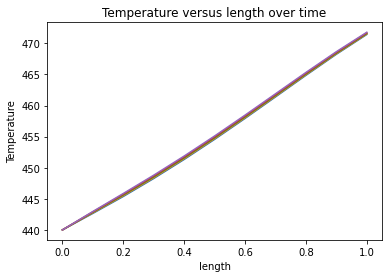

In [21]:
## Temperature profile along the length of reactor over time

count=0
TA0=[]
TA1=[]
TA2=[]
TA3=[]
TA4=[]
TA5=[]

for i in T_physics_output[0]:
    print(i)
    for j in i:
        #print(j)
        if count==0:
            TA0.append(j)
        if count==1:
            TA1.append(j)
        if count==2:
            TA2.append(j)
        if count==3:
            TA3.append(j)
        if count==4:
            TA4.append(j)
        if count==5:
            TA5.append(j)
    count=count+1
    
    
    
    
N = 11     # number of points to discretize the reactor volume on
z = np.linspace(0, length, N) # discretized volume elements
#plt.plot(z, CA0)
plt.plot(z, TA1)
plt.plot(z, TA2)
plt.plot(z, TA3)
plt.plot(z, TA4)
plt.plot(z, TA5)

plt.xlabel("length")
plt.ylabel("Temperature")
plt.title("Temperature versus length over time")

Text(0.5, 1.0, 'temp versus length over time')

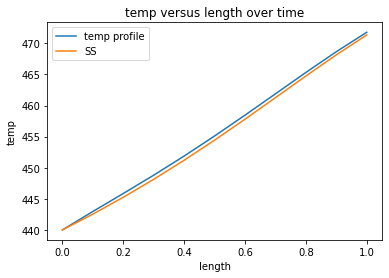

In [22]:
## Plot comparing the steady state and PFR simulation profiles for temperature

T_ss=[440, 442.537980203289, 445.24937842606676, 448.1391353316486, 451.20586746040226, 454.43809815470087, 457.80935816302986, 461.2725883629541, 464.75519617827314, 468.1574151982801, 471.3575957995257]
N = 11     # number of points to discretize the reactor volume on
z = np.linspace(0, length, N) # discretized volume elements
plt.plot(z, TA5, label='temp profile')

    
N = 11     # number of points to discretize the reactor volume on
z = np.linspace(0, length, N) # discretized volume elements
plt.plot(z, T_ss, label= 'SS')

plt.legend()

plt.xlabel("length")
plt.ylabel("temp")
plt.title("temp versus length over time")